In [12]:
from torch.utils.data import Dataset
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from random import randint
from augment_functions import (
    random_mask,
    resize_encoder,
    augment_sample,
    augment_sample_random_mask,
)
from sklearn.metrics.pairwise import pairwise_distances

In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        X = augment_sample(x_orig)
        X_prime = augment_sample_random_mask(
            x_orig, random_mask_prob=self.mask_prob
        )
        y = idx
        return x_orig, x, masked_x, y, X, X_prime

In [15]:
model = torch.load(
    "barlow_twins.pth", weights_only=False, map_location=DEVICE
)
model.eval()

model = model.encoder

BATCH_SIZE = 20
data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
train_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
y = batch[3].to(DEVICE)

print(x.shape)

torch.Size([20, 5, 144, 72])


In [17]:
with torch.no_grad():
    embeddings_x, _ = model(x)
    embeddings_masked_x, _ = model(masked_x)

[95.92894  77.904076 63.13092  69.91446  51.879974 89.59972  67.59421
 64.0349   62.99136  79.48025  63.774837 68.55752  73.81404  81.22074
 58.26338  86.09616  79.21776  72.89369  78.83814  88.132416]


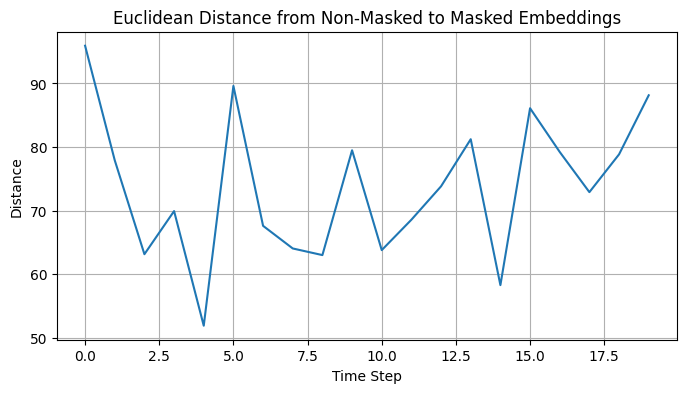

In [18]:
dist = np.linalg.norm(embeddings_x - embeddings_masked_x, axis=1)
print(dist)
plt.figure(figsize=(8, 4))
plt.plot(dist)
plt.title(f"Euclidean Distance from Non-Masked to Masked Embeddings")
plt.xlabel("Time Step")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

In [19]:
embeddings_x = embeddings_x.cpu().numpy()
embeddings_masked_x = embeddings_masked_x.cpu().numpy()
y = y.cpu().numpy()

combined = np.vstack([embeddings_x, embeddings_masked_x])
pca = PCA(n_components=2)
combined_proj = pca.fit_transform(combined)

x_proj = combined_proj[: len(embeddings_x)]
x_prime_proj = combined_proj[len(embeddings_x) :]


df = pd.DataFrame(
    {
        "x": np.concatenate([x_proj[:, 0], x_prime_proj[:, 0]]),
        "y": np.concatenate([x_proj[:, 1], x_prime_proj[:, 1]]),
        "group": ["A"] * BATCH_SIZE + ["B"] * BATCH_SIZE,
        "point_id": list(range(BATCH_SIZE)) * 2,
    }
)

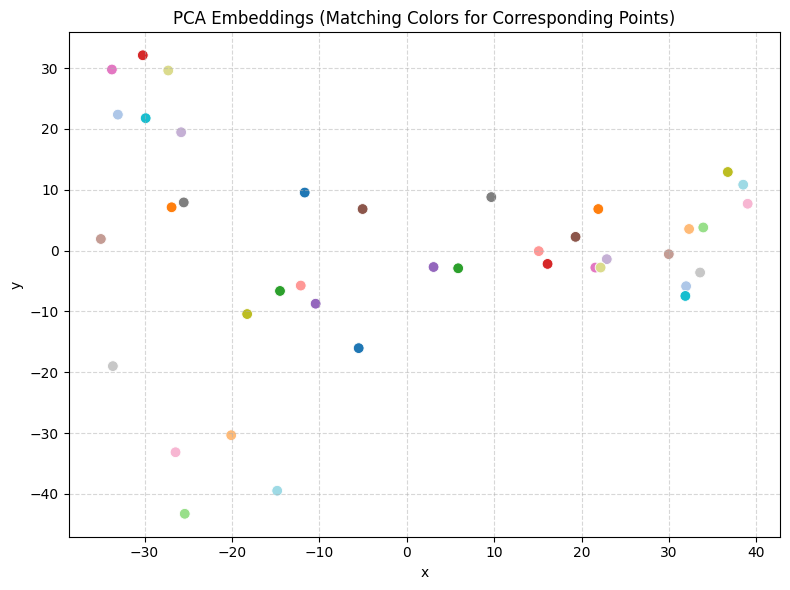

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue="point_id", palette="tab20", s=60)
plt.legend().remove()
plt.title("PCA Embeddings (Matching Colors for Corresponding Points)")
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
df = pd.DataFrame(
    {"x": x_prime_proj[:, 0], "y": x_prime_proj[:, 1], "labels": y}
)

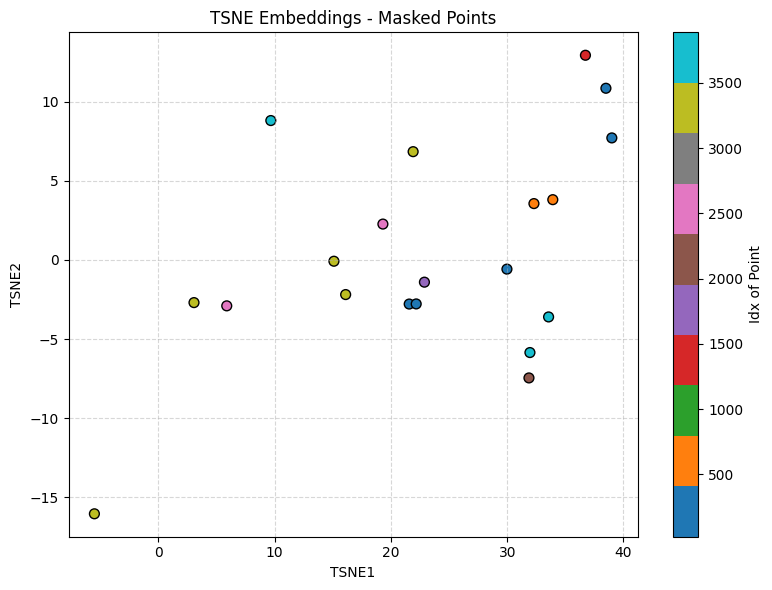

In [22]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["x"], df["y"], c=df["labels"], cmap="tab10", s=50, edgecolors="k"
)
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.title("TSNE Embeddings - Masked Points")
plt.colorbar(scatter, label="Idx of Point")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()